# KNN from scratch
## made by Clement Decoopman

## Librairies
***

In [1]:
from functools import reduce
from tqdm import tqdm

import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

from knn import knn

## Scale transform
***
This transformation avoid data leakage in the given dataset.

In [2]:
def scale_transform(X_train: list, X_test: list) -> list:
    """Applies a scale transformation to data to avoid data leakage.
    
    Parameters
    -----
        X_train (list) -- training data
        X_test (list) -- test data

    Returns
    -----
        list -- both transformed datasets (train / test)
    """
    scaler  = StandardScaler()
    return scaler.fit_transform(X_train), scaler.transform(X_test)

## Confidence interval
***

In [3]:
from statistics import NormalDist


def confidence_interval(data: list, confidence: float=0.95) -> list:
    """Compute the confidence interval for a given dataset.
    
    Parameters
    -----
        data (list) -- dataset
        confidence (float) -- confidence value, should be in [0.90, 0.95, 0.99] (default: 0.95)
    
    Raises
    -----
        ValueError -- the given confidence value is not among [0.90, 0.95, 0.99]
    
    Returns
    -----
        list -- resulting confidence interval

    """
    acceptedConfidences = [0.90, 0.95, 0.99]
    if confidence not in acceptedConfidences:
        raise ValueError(f'given confidence value {confidence} not in {acceptedConfidences}')

    dist = NormalDist.from_samples(data)
    z    = NormalDist().inv_cdf((1 + confidence) / 2.0)
    h    = dist.stdev * z / ((len(data) - 1) ** 0.5)

    return [dist.mean - h, dist.mean + h]

## KNN functions
***

### Minkowski distance

In [4]:
def minkowski(a: list, b: list, p: int=1) -> float:
    """Compute the Minkowski distance between 2 data points.
    Each data points should have the same dimension.

    Parameters
    -----
        a (list) -- First data point
        b (list) -- Second data point
        p (int) -- minkowski parameter (default: 1)
    
    Returns
    -----
        float -- Manhattan (p=1), Euclidian (p=2), ... distance between the two data points. 
    """
    dist = 0
    try:
        for i in range(len(a)):     # we assume a and b have the same dim
            dist += abs(a[i] - b[i])**p
        dist **= (1/p)

    except IndexError as err:
        dist = None
        print(f"{err} : dim {len(a)} should match dim {len(b)}")
    
    return dist

### KNN algorithm

In [5]:
def knn(X_train: np.ndarray, X_test: np.ndarray, Y_train: pd.DataFrame, k: int=3, p: int=1) -> list:
    """KNN algorithm made from scratch.
    
    Parameters
    -----
        X_train (np.ndarray) -- training data points
        X_test (np.ndarray) -- data points on which predictions are made
        Y_train (pd.DataFrame) -- training labels
        k (int) -- number of neighbours to consider (default: 3)
        p (int) -- minkowski parameter (default: 1)

    Returns
    -----
        list -- predictions about the class of each test point
    """
    from collections import Counter
    predictions = []

    # Compute for each data point in the test set
    for test_point in X_test:
        distances = []

        for train_point in X_train:
            dist = minkowski(test_point, train_point, p=p)
            if dist: distances.append(dist)

        # Getting the k-nearest neighbours if there are ones
        if distances:
            df_dists = pd.DataFrame(data=distances, columns=['distance'], index=Y_train.index)  # store distances in a DF
            df_nn    = df_dists.sort_values(by='distance')[:k]                        # sort distances and keep the k closest ones

            # Classify the data point
            counter = Counter(Y_train[df_nn.index])     # track labels of k nearest neighbours
            predict = counter.most_common()[0][0]       # get the most common label among neighbours
            predictions.append(predict)

    return predictions

## Evaluation functions
***

### Train-test validation

In [6]:
def train_test_validation(dataset: pd.DataFrame, test_size: float=0.25, k: int=3, p: int=2) -> float:
    """Execute a train-test validation on a given dataset with the KNN algorithm.
    
    Parameters
    -----
        dataset (pd.DataFrame) -- dataset as a pandas Dataframe
        test_size (float) -- part of the dataset given for testing (default: 0.25)
        k (int) -- KNN parameter (default: 3)
        p (int) -- Minkowski parameter (default: 2)
    
    Returns
    -----
        float -- global accuracy score.
    """
    X = dataset.drop('target', axis=1)
    Y = dataset.target
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=1, shuffle=True)

    # scale transformation
    X_train, X_test = scale_transform(X_train, X_test)

    # make preditions
    predictions = knn(X_train, X_test, Y_train, k, p)
    return accuracy_score(Y_test, predictions)

### Cross-validation

In [7]:
def cross_validation(dataset: pd.DataFrame, n: int=5, k: int=3, p: int=2) -> float:
    """Compute a cross-validation on the given dataset.
    
    Parameters
    -----
        dataset (pd.DataFrame) -- [description]
        n (int) -- number of chunks (default: 5)
        k (int) -- KNN parameter (default: 3)
        p (int) -- Minkowski parameter (default: 2)

    Returns
    -----
        float -- mean accuracy score from all batches accuracy.a
    """
    scores = []
    data   = shuffle(dataset, random_state=5)       # shuffle the dataset
    chunks = np.array_split(data, n)                # split into equals chunks

    for chk in chunks:

        # defining train and test set
        test  = chk
        train = pd.concat([df for df in chunks if not df.equals(chk)])

        # separating data and target
        X_train, Y_train = train.drop('target', axis=1), train.target
        X_test, Y_test   = test.drop('target', axis=1), test.target

        # avoiding data leakage
        X_train, X_test = scale_transform(X_train, X_test)

        # make prediction for the current chunk
        predictions = knn(X_train, X_test, Y_train, k, p)
        accuracy    = accuracy_score(Y_test, predictions)
        scores.append(accuracy)

    sum = reduce(lambda x,y: x+y, scores)
    return sum/len(scores)

## Import dataset
***

In [8]:
from sklearn.datasets import load_wine

# load the wine dataset
wines = load_wine()
data  = pd.DataFrame(data=wines.data, columns=wines.feature_names)
data['target'] = wines.target

# separating data and target
X = data.drop('target', axis=1)
Y = data.target

## Data exploration
***

### Shape of the dataset

In [9]:
print(X.describe(), '\n')
print(data.groupby('target').size())   # showing classes distribution

          alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453         0.572359   
min         0.9

### Correlation matrix

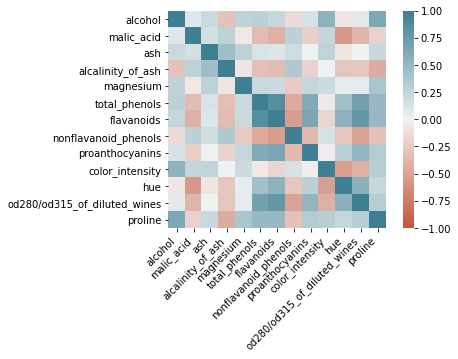

In [10]:
from knn_plots import corrMatrix
corrMatrix(X)

## Comparison between train-test validation and cross-validation
***

### KNN params

In [11]:
k = 5
p = 2

### Train-test validation
A simple train-test validation with 25% of data given to testing.
> ~97.77% of accuracy

In [12]:
test_size = 0.25
TT_acc = train_test_validation(data, test_size, k, p)
print("KNN train_test validation accuracy score : {}".format(TT_acc))

KNN train_test validation accuracy score : 0.9777777777777777


### Cross-validation
Using cross-validation, we now have a more precise value of total accuracy.
> ~97.19% of accuracy

In [13]:
n = 5
cross_acc = cross_validation(data, n, k, p)
print("KNN cross validation accuracy score : {}".format(cross_acc))

KNN cross validation accuracy score : 0.9719047619047618


## Search the optimal value of n for cross validation
***
The interval of n we are searching in shouldn't be too big, because a high value can leads to overfiting.

100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


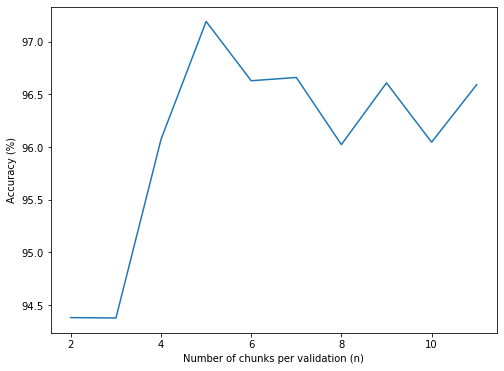

Best cross_validation n value : 5


In [17]:
    
from knn_plots import cross_varrying_effect

cross_accuracies = []
nMax = 12
k = 5
p = 2

for ni in tqdm(range(2, nMax)):
    acc = cross_validation(data, ni, k, p)
    cross_accuracies.append(acc)

cross_accuracies = list(map(lambda x: x*100, cross_accuracies))
cross_varrying_effect(cross_accuracies, nMax)
best_n = np.argmax(cross_accuracies) + 2
print(f'Best cross_validation n value : {best_n}')


## Confidence interval for cross-validation
***

In [20]:
confidence = 0.95
conf_interval = confidence_interval(cross_accuracies, confidence)
print(f'{confidence*100}% confidence interval for cross-validation : \n {conf_interval}')

95.0% confidence interval for cross-validation : 
 [95.43482863631336, 96.68107743187731]


## Observe the effects of varying the k parameter in KNN
***
Using the previous best N-cross-validation parameter, we observe that the best accuracy is given when k=5.

100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


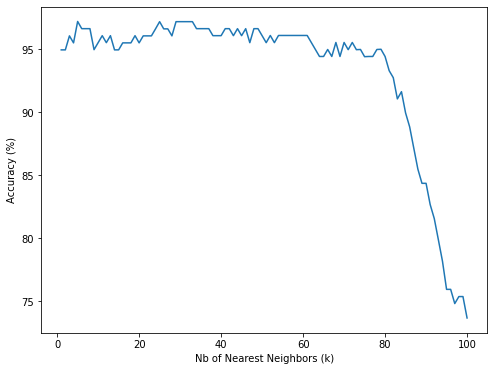

Best k value : 5


In [16]:
from knn_plots import k_varying_effect

p = 2
kmax = 101
test_size = 0.25
k_accuracies = []

for ki in tqdm(range(1, kmax)):
    acc = cross_validation(data, best_n, ki, p)
    k_accuracies.append(acc)

k_accuracies = list(map(lambda x: x*100, k_accuracies))
k_varying_effect(k_accuracies, kmax)
best_k = np.argmax(k_accuracies) + 1
print(f'Best k value : {best_k}')